In [134]:
%matplotlib inline
import math
from modsim import *

For this model we're assuming that our mass begins in a geostationary orbit (perhaps a docking orbit for a cargo mission) and will be going to the moon. <br>
<br>
r0 = 42,164 km <br>
rf = 384,400 km <br>
<br>
To figure out what the necessary delta-v is we look at a Hohmann transfer.  Hohmann transfers are the most efficient means of switching circular orbits and involve two burns that sum to a net delta-v.  These are well-known, used, and documented calculations and explanations can be found readily online.  For this lab I used an online calculator found at the link below: <br>
<br>
https://instacalc.com/42836 <br>
<br>
According to this calculator the delta-v for the first maneuver is 956.61 m/s and for the second maneuver is 535.22 m/s, resulting in a net delta-v of 1491.83 m/s.  For this model, <b>1492 m/s is the target delta-v.</b>

In [125]:
r0 = 42164000    # in meters
rf = 384400000   # in meters
dv = 1492        # in meters/sec

Let's create a rocket object

In [126]:
vExhaust = 0     # Engine exhaust velocity
mDry = 1000      # Dry mass of the spacecraft (only rocket + payload)
mFuel = 0    # Mass of spacecraft fuel

rocket = System(vExhaust=vExhaust, mDry=mDry, mFuel=mFuel)

Let's initialize the exhaust velocities for a couple kinds of engines that our spacecraft could have. <br>
https://en.wikipedia.org/wiki/Specific_impulse#Examples <br>
https://en.wikipedia.org/wiki/Spacecraft_propulsion#Table_of_methods

In [142]:
SRB = 2500     # Space shuttle solid rocket booster
LH2 = 4400     # Liquid hydrogen rocket
Arc = 16000    # Arcjet rocket
PPT = 20000    # Pulsed plasma thruster
Ion = 29000    # Electrostatic ion thruster
Hall = 50000   # Electric Hall-effect thruster
Sail = 299792  # Solar sail (effectively no fuel)

engines = [SRB, LH2, Arc, PPT, Ion, Hall, Sail]    # Array of engines
initGuesses = [800, 400, 90, 70, 50, 20, 0]        # Array of initial guesses for each engine
names = ["SRB", "LH2", "Arc", "PPT", "Ion", "Hall", "Sail"]    # Array of engines

The below function solves for delta-v via a straight rocket equation calculation determined by a ratio of dry to wet masses given an exhaust velocity.

In [128]:
def solveV(r):
    
    # Calculate the change in velocity via the base rocket equation
    dv = r.vExhaust * math.log((r.mDry + r.mFuel) / r.mDry)
    
    return dv

The below function takes in a value for the mass of the rocket's fuel, solves for the dv achieved by that mass of fuel, and returns the difference between the achieved delta-v and the desired delta-v.

In [129]:
def error_func(mFuel):
    r = rocket
    r.mFuel = mFuel
    vf = solveV(r)

    return vf - dv    # Where dv is a reference to the target velocity

Let's pick an engine for the rocket and see what we can do with fsolve:

In [130]:
rocket.vExhaust = LH2

try:
    solution = fsolve(error_func, 400, xtol=1e-3)
except:
    print("Math range error")
    
solution[0]


404.67308281054034

By direct back-solving, the entire initial mass is 1404.7121, which means the fuel mass is 404.7121 so we're pretty close.<br>
http://www.quantumg.net/rocketeq.html
<br><br>
Cool, now let's try sweeping the engines:

In [131]:
for i in range(0, len(engines)-1):

    rocket.vExhaust = engines[i]
    initGuess = initGuesses[i]

    try:
        solution = fsolve(error_func, initGuess, xtol=1e-3)
    except:
        print("Math range error at index " + str(i))
        
    print("Engine " + str(i) + " requires " + str(solution[0]) + " kg of fuel")

Engine 0 requires 816.436672487 kg of fuel
Engine 1 requires 404.673082811 kg of fuel
Engine 2 requires 98.8111091336 kg of fuel
Engine 3 requires 77.5253479439 kg of fuel
Engine 4 requires 53.0359786928 kg of fuel
Engine 5 requires 30.6118325058 kg of fuel


*** Turns out we get a lot of math errors because of fsolve *** <br><br>
But otherwise, great, glad it works! <br><br>Next we need to pick a single thruster and vary the dry mass of our spacecraft.

In [140]:
rocket.vExhaust = LH2
initGuess = 100             #initGuesses[engines.index(LH2)]

sweep = SweepSeries()

for mDry in linrange(500, 2000, 100):   # Let's sweep 500-2000kg in increments of 100kg
    rocket.mDry = mDry 
    try:
        solution = fsolve(error_func, initGuess, xtol=1e-3)
    except:
        print("Math range error at index " + str(i))
        
    sweep[mDry] = solution[0]
    
print(sweep)

500     202.194998
600     242.135314
700     283.024253
800     323.410432
900     363.089151
1000    404.347826
1100    444.771133
1200    484.582565
1300    525.361066
1400    565.664022
1500    606.445925
1600    646.263783
1700    686.585916
1800    727.474485
1900    767.082882
2000    807.303732
dtype: float64


Now can we plot the results?

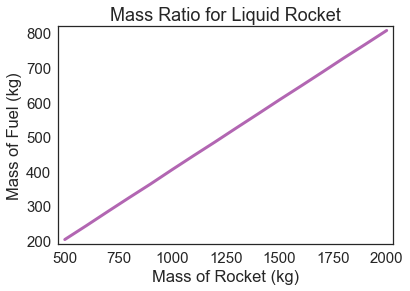

In [141]:
plot(sweep, color='purple')
decorate(title='Mass Ratio for Liquid Rocket',
         xlabel='Mass of Rocket (kg)',
         ylabel='Mass of Fuel (kg)',
         legend=False)

***  Hmm.  Let's think about if this is the right relationship or not  *** <br><br>
Next let's sweep this range for every engine and see what happens

In [158]:
frame = SweepFrame()
sweep = SweepSeries()

for i in range(0, len(engines)):

    rocket.vExhaust = engines[i]
    initGuess = initGuesses[i] * 0.1

    for mDry in linrange(500, 2000, 100):   # Let's sweep 500-2000kg in increments of 100kg
        rocket.mDry = mDry 
        try:
            solution = fsolve(error_func, initGuess, xtol=1e-2)
        except:
            print("Math range error at index " + str(i))

        sweep[mDry] = solution[0]
    
    frame[names[i]] = sweep
        
frame

,SRB,LH2,Arc,PPT,Ion,Hall,Sail
500,408.305938,202.284767,49.049383,39.868556,26.681032,15.534059,2.729674
600,490.716154,242.631677,59.193813,46.821829,32.479762,18.634224,3.228519
700,571.941480,282.395336,69.835018,54.524241,37.428319,21.712854,3.727052
800,653.958109,323.659271,78.935175,62.097589,42.302041,24.776947,4.225383
900,735.329555,363.475726,88.772964,70.940808,48.363259,27.948419,4.723576
1000,816.421623,404.121816,98.215871,78.618716,53.450200,30.877144,5.221671
1100,898.681748,444.246951,108.285618,85.415536,58.526304,33.917864,5.719693
1200,979.693424,484.671315,117.333046,93.902771,63.685436,36.954241,6.217661
1300,1061.338641,525.774723,127.780211,101.439718,69.193911,39.987202,6.715585
1400,1143.683433,565.346988,137.113040,109.637588,74.693945,42.068779,7.213476


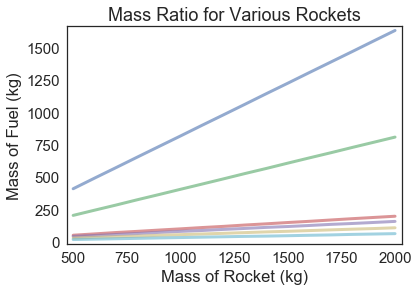

In [159]:
for i in range(0, len(engines)-1):
    label = names[i]
    plot(frame[label], label=label)

decorate(title='Mass Ratio for Various Rockets',
         xlabel='Mass of Rocket (kg)',
         ylabel='Mass of Fuel (kg)',
         legend=False)

*** Okay, now it's really time to check if linear is the right relationship or not *** <br><br>
But right now it's 2 in the morning and I'm done for the night (:

Actually wait I just had a guess at how to graph the real relationship we want and I'm listening to "Don't Stop Me Now" by Queen so I'm invincible and ready to finish this thing

In [161]:
finalFrame = SweepFrame()

for name in names:
    
    series = frame[name]
    temp = SweepSeries()
    dryMasses = series.index.tolist()
    fuelMasses = series.values.tolist()
    
    for i in range(0, len(dryMasses)-1):
        temp[dryMasses[i]] = dryMasses[i] + fuelMasses[i]
        
    finalFrame[name] = temp
        
finalFrame

,SRB,LH2,Arc,PPT,Ion,Hall,Sail
500,908.305938,702.284767,549.049383,539.868556,526.681032,515.534059,502.729674
600,1090.716154,842.631677,659.193813,646.821829,632.479762,618.634224,603.228519
700,1271.941480,982.395336,769.835018,754.524241,737.428319,721.712854,703.727052
800,1453.958109,1123.659271,878.935175,862.097589,842.302041,824.776947,804.225383
900,1635.329555,1263.475726,988.772964,970.940808,948.363259,927.948419,904.723576
1000,1816.421623,1404.121816,1098.215871,1078.618716,1053.450200,1030.877144,1005.221671
1100,1998.681748,1544.246951,1208.285618,1185.415536,1158.526304,1133.917864,1105.719693
1200,2179.693424,1684.671315,1317.333046,1293.902771,1263.685436,1236.954241,1206.217661
1300,2361.338641,1825.774723,1427.780211,1401.439718,1369.193911,1339.987202,1306.715585
1400,2543.683433,1965.346988,1537.113040,1509.637588,1474.693945,1442.068779,1407.213476


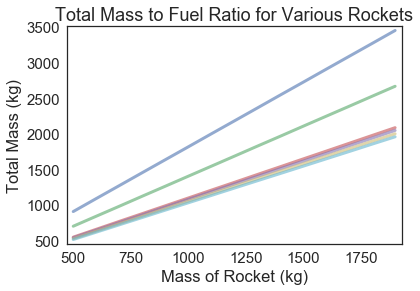

In [162]:
for i in range(0, len(engines)-1):
    label = names[i]
    plot(finalFrame[label], label=label)

decorate(title='Total Mass to Fuel Ratio for Various Rockets',
         xlabel='Mass of Rocket (kg)',
         ylabel='Total Mass (kg)',
         legend=False)

*** Hmm okay this is really interesting.  What are your thoughts about what we do next?  Check out the main graphic on this wikipedia page for the graph I was actually thinking of...***

https://en.wikipedia.org/wiki/Tsiolkovsky_rocket_equation

*** FYI, Connor Novak liked the graph before this one, he called it a good punchline graph ***
